# Sample et al. Human MPTA Dataset (5'UTR polysome profiling)

- Paper link: https://www.nature.com/articles/s41587-019-0164-5
- Data link: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE114002

## 1- Dataset preprocessing

In [1]:
import wandb
import tempfile
import pandas as pd
import seaborn as sns

wandb.login(host = "https://genentech.wandb.io" )
from grelu.resources import artifacts, get_model_by_dataset, get_dataset_by_model



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: uehara-masatoshi. Use `wandb login --relogin` to force relogin
/home/ueharam1/miniconda3/envs/GRELU1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
run = wandb.init(entity='grelu', project='human-mpta-sample-2019', job_type='preprocessing', name='prep') # Initialize a W&B Run
run.name

wandb: Currently logged in as: uehara-masatoshi (grelu). Use `wandb login --relogin` to force relogin


'prep'

### Download from GEO

In [3]:
unmod1_egfp = pd.read_csv('https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM3130435&format=file&file=GSM3130435%5Fegfp%5Funmod%5F1%2Ecsv.gz', index_col=0)[['utr', 'rl']]
unmod2_egfp = pd.read_csv('https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM3130436&format=file&file=GSM3130436%5Fegfp%5Funmod%5F2%2Ecsv.gz', index_col=0)[['utr', 'rl']]

unmod1_mcherry = pd.read_csv('https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM3130441&format=file&file=GSM3130441%5Fmcherry%5F1%2Ecsv.gz', index_col=0)[['utr', 'rl']]
unmod2_mcherry = pd.read_csv('https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM3130442&format=file&file=GSM3130442%5Fmcherry%5F2%2Ecsv.gz', index_col=0)[['utr', 'rl']]

designed = pd.read_csv('https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM3130443&format=file&file=GSM3130443%5Fdesigned%5Flibrary%2Ecsv.gz', index_col=0)[['utr', 'rl']]

/tmp/ipykernel_2337873/1516276072.py:7: DtypeWarning: Columns (33,34,35,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  designed = pd.read_csv('https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM3130443&format=file&file=GSM3130443%5Fdesigned%5Flibrary%2Ecsv.gz', index_col=0)[['utr', 'rl']]


In [4]:
len(set(unmod1_egfp.utr.unique()) & set(unmod2_egfp.utr.unique()))

0

In [5]:
len(set(unmod1_egfp.utr.unique()) & set(unmod1_mcherry.utr.unique()))

0

In [6]:
unmod1_egfp.shape

(326033, 2)

In [7]:
unmod2_egfp.shape

(351575, 2)

In [8]:
#df = pd.concat([unmod1_egfp, unmod2_egfp, designed], axis=0).reset_index(drop=True)
df = pd.concat([unmod1_egfp], axis=0).reset_index(drop=True)
df

,utr,rl
0,CCACTCGATTAACATGTTAACAACATACTCGTCCGGCCGATCAGCG...,3.039939
1,CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTA...,3.895109
2,GTTATACTAGAAGAAACTTGAGATTATGGAGCAGTCCGTCAAGGAC...,3.334524
3,CTTAGACAAAAACAACGCGCTTTCCAGTATGCGGAGCCTTGACGGT...,3.575082
4,GTATCAAATCACGGCCAACCCGACGGAGTACCCCGCGTCGATGGTC...,4.593712
...,...,...
326028,ACTAACGTGGGGCCTAAACAAGTGCAAACACCCCCACGGACCCCCA...,5.800000
326029,GAAAGCGGTTGAAACTACTCATACGTACAAGGTAAACATTTAAAAG...,5.800000
326030,GGCTATGGCCGAAATAAATAAAGCGCGAGCCCGTAGGTACGAGCAA...,0.000000
326031,CCGGCCAGTGCGCTGAAATACGTATAAGGTGGGTCGACGTAAAAAA...,5.800000


In [9]:
df.shape

(326033, 2)

In [10]:
#df.utr.str.len().value_counts()

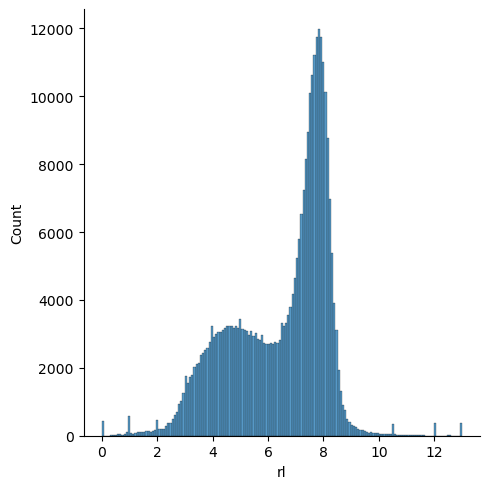

In [11]:
sns.displot(df.rl)

In [12]:
from sklearn.preprocessing import StandardScaler

df['rl'] = StandardScaler().fit_transform(df.rl.values.reshape(-1, 1))

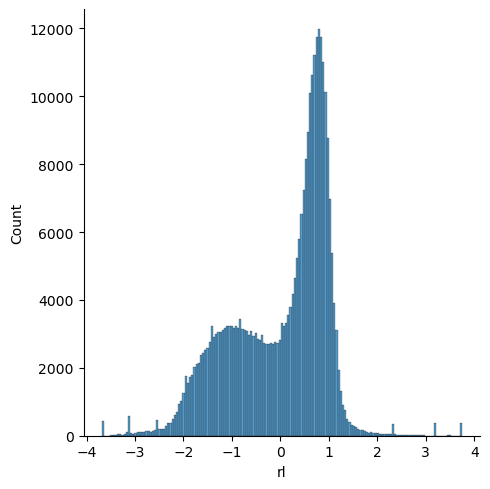

In [13]:
sns.displot(df.rl)

### Save the dataset as a dataset artifact

In [14]:
artifact = wandb.Artifact('dataset', type='dataset')

df.to_csv('dataset.csv.gz')
artifact.add_file('dataset.csv.gz')
run.log_artifact(artifact)

In [15]:
wandb.finish()

In [16]:
artifacts('human-mpta-sample-2019')

['dataset', 'model-8mpf6vda', 'model-cegutyy1', 'model', 'model-027lcve7']

***

## 2- Model training

In [3]:
import wandb
import torch
import grelu
import pandas as pd

from grelu.resources import artifacts, get_model_by_dataset, get_dataset_by_model

In [4]:
run = wandb.init(entity='grelu', project='human-mpta-sample-2019', job_type='training', name='train')
run.name

'train'

### Load the dataset

In [7]:
artifact = run.use_artifact('dataset:v3')
artifact

<Artifact QXJ0aWZhY3Q6Mjc1NTY1Mw==>

In [8]:
dir = artifact.download()

wandb:   1 of 1 files downloaded.  


In [9]:
df = pd.read_csv(dir + '/dataset.csv.gz', index_col=0)
df.head()

,utr,rl
0,CCACTCGATTAACATGTTAACAACATACTCGTCCGGCCGATCAGCG...,-1.949703
1,CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTA...,-1.460671
2,GTTATACTAGAAGAAACTTGAGATTATGGAGCAGTCCGTCAAGGAC...,-1.781243
3,CTTAGACAAAAACAACGCGCTTTCCAGTATGCGGAGCCTTGACGGT...,-1.643680
4,GTATCAAATCACGGCCAACCCGACGGAGTACCCCGCGTCGATGGTC...,-1.061173


### Train/Val/Test split by chromosome

In [10]:
import grelu.data.preprocess
from sklearn.model_selection import train_test_split

In [11]:
df_train, df_test = train_test_split(df, test_size=0.2)
df_test, df_val = train_test_split(df_test, test_size=0.5)

In [12]:
df_train.shape

(260826, 2)

In [13]:
df_test.shape

(32603, 2)

In [14]:
df_val.shape

(32604, 2)

### Start the training!

In [15]:
model_params = {
    'model_type':'EnformerPretrainedModel',
    'n_tasks': 1,
    'n_transformers': 1,
}

train_params = {
    'task':'regression',
    'loss': 'MSE',
    'lr':1e-4,
    'logger': 'wandb',
    'batch_size': 512,
    'num_workers': 4,
    'devices': [4],
    'save_dir': 'experiment',
    'optimizer': 'adam',
    'max_epochs': 20,
    'checkpoint': True,
}

In [16]:
#import grelu.model.run
import grelu.lightning
import grelu.data.dataset

In [17]:
# Make labeled datasets
train_dataset = grelu.data.dataset.DFSeqDataset(df_train)
val_dataset   = grelu.data.dataset.DFSeqDataset(df_val)

# Build model
model = grelu.lightning.LightningModel(model_params=model_params, train_params=train_params)

Sequences will be extracted from columns ['utr']
Sequences will be extracted from columns ['utr']


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.6


In [18]:
# Train model
trainer = model.train_on_dataset(train_dataset, val_dataset)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ueharam1/miniconda3/envs/GRELU1/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Validation DataLoader 0: 100%|██████████| 64/64 [00:02<00:00, 29.92it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss             1.009838581085205
         val_mse            1.0097399950027466
       val_pearson         -0.007566484622657299
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/ueharam1/miniconda3/envs/GRELU1/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name         | Type                    | Params | Mode 
-----------------------------------------------------------------
0 | model        | EnformerPretrainedModel | 71.4 M | train
1 | loss         | MSELoss                 | 0      | train
2 | activation   | Identity                | 0      | train
3 | val_metrics  | MetricCollection        | 0      | train
4 | test_metrics | MetricCollection        | 0      | train
5 | transform    | Identity                | 0      | train
-----------------------------------------

/home/ueharam1/miniconda3/envs/GRELU1/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 19: 100%|██████████| 510/510 [00:26<00:00, 19.19it/s, v_num=364q, train_loss_step=0.184, train_loss_epoch=0.189]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 510/510 [00:27<00:00, 18.36it/s, v_num=364q, train_loss_step=0.184, train_loss_epoch=0.189]


### Save the model

In [19]:
artifact = wandb.Artifact('model', type='model')

artifact.add_file(trainer.checkpoint_callback.best_model_path, 'model.ckpt')
run.log_artifact(artifact)

<Artifact model>

In [20]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train_loss_epoch,█▆▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁▁▁
train_loss_step,█▇▅▆▅▅▄▄▄▅▄▄▃▅▃▃▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂
val_mse,█▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂
val_pearson,▁▆▇█████████▇▇▇▇▇▇▇▇▇
epoch,19
train_loss_epoch,0.18948
train_loss_step,0.18434
trainer/global_step,10199


***

## 3- Test model

In [21]:
test_dataset = grelu.data.dataset.DFSeqDataset(df_test)
model.test_on_dataset(test_dataset, devices=[1], num_workers=4)

Sequences will be extracted from columns ['utr']


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ueharam1/miniconda3/envs/GRELU1/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 0: 100%|██████████| 128/128 [00:02<00:00, 55.99it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7943534851074219
        test_mse             0.794555127620697
      test_pearson          0.5348474383354187
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,test_mse,test_pearson
rl,0.794555,0.534847


### Correlation plots for each cell type

In [22]:
preds = model.predict_on_dataset(test_dataset, devices=[1])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/ueharam1/miniconda3/envs/GRELU1/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 128/128 [00:01<00:00, 65.82it/s]


### Correlation on test set

In [23]:
from grelu.visualize import plot_pred_scatter

In [24]:
import numpy as np

0.5348473340008766


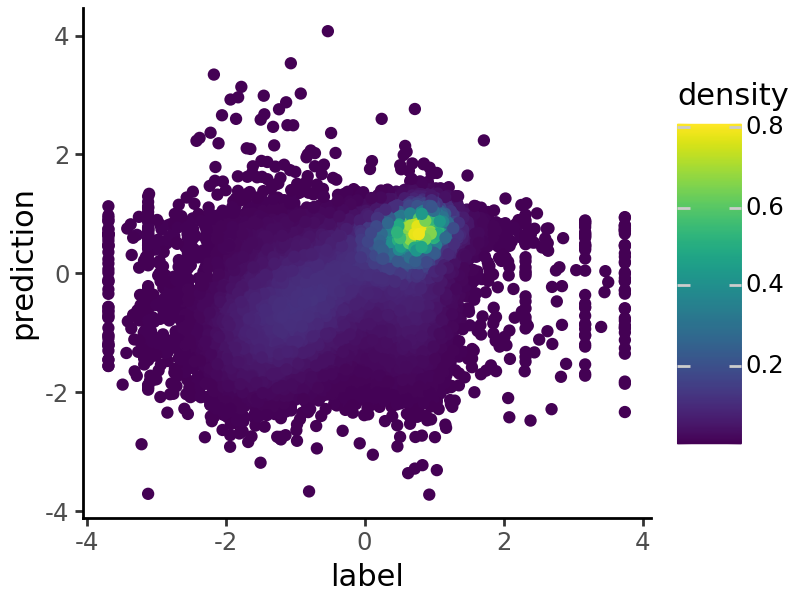

In [25]:
print(np.corrcoef(preds.squeeze(), test_dataset.labels.squeeze())[0][1])
plot_pred_scatter(preds, test_dataset.labels, density = True)

## Query via gReLU Resources API

In [41]:
#get_model_by_dataset('dataset', 'human-mpta-sample-2019')

In [42]:
#get_dataset_by_model('model', 'human-mpta-sample-2019')

## Load model to test

In [39]:
from grelu.resources import load_model

model = load_model('human-mpta-sample-2019', 'model')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Downloading large artifact model:latest, 1180.46MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:3.7


## Design 5' UTRs

In [54]:
from grelu.design.evolve import evolve

In [55]:
df_test

,utr,rl
180865,TGTTACTAAGGCCAACGTACTGCAGTAGGCATGTTAGGGAAGCATG...,-0.004283
6227,AAAGTGTTCATGGACATAACTTGCGGAGCGAAACAAGGGTACAGCC...,-1.018953
55289,CTCCCCCAGGCTCTTGGGAGGATCTCTCTTACTGGAGTGTAAGTTC...,0.789420
103600,CCGGCCAACCGATCCTCACCTGTTAGGGGCTTACGGAACCCAGAAG...,0.790365
253824,CGCGGATAATTCAAAGCAATAGAAGCTCTTTCCAATATAGGGCAAA...,0.543703
...,...,...
214923,CTGGAGTGAGACTTGTGATGTCCATGGTAAATCCACAGGGGTTCGA...,0.846298
130074,CGTAACACTGCCGGCACATAATACACCGATATAAGGTGTATCAGGC...,0.569078
10883,AACCTCCAGCGTACAAGAGACTCACTTACCTCCGATAAGGCTGTCG...,0.586346
260256,TGAACTACGTGGAGTGGAATAAATGCGAAGTATCAGTGATAAACCA...,0.550773


In [56]:
df.utr.str.len().value_counts()

utr
50    326033
Name: count, dtype: int64

In [57]:
start_seqs = df_test[df_test.utr.str.len()==50]

In [58]:
start_seqs = start_seqs.sort_values('rl').utr.iloc[:200].tolist()

In [59]:
designed_elements = evolve(start_seqs, model, max_iter=20, devices=[1])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Iteration 1


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Best loss at iteration 1: Total loss=-0.866, Individual losses=[-0.8660108]
Iteration 2


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Best loss at iteration 2: Total loss=-0.953, Individual losses=[-0.95312315]
Iteration 3


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best loss at iteration 3: Total loss=-0.998, Individual losses=[-0.99788004]
Iteration 4


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best loss at iteration 4: Total loss=-1.022, Individual losses=[-1.0224195]
Iteration 5


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best loss at iteration 5: Total loss=-1.045, Individual losses=[-1.0445131]
Iteration 6


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best loss at iteration 6: Total loss=-1.059, Individual losses=[-1.0586232]
Iteration 7


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best loss at iteration 7: Total loss=-1.084, Individual losses=[-1.0837965]
Iteration 8


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best loss at iteration 8: Total loss=-1.112, Individual losses=[-1.1116327]
Iteration 9


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best loss at iteration 9: Total loss=-1.129, Individual losses=[-1.1286526]
Iteration 10


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best loss at iteration 10: Total loss=-1.149, Individual losses=[-1.1485435]
Iteration 11


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best loss at iteration 11: Total loss=-1.174, Individual losses=[-1.1744361]
Iteration 12


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best loss at iteration 12: Total loss=-1.188, Individual losses=[-1.1879895]
Iteration 13


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best loss at iteration 13: Total loss=-1.188, Individual losses=[-1.1880372]
Iteration 14


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best loss at iteration 14: Total loss=-1.192, Individual losses=[-1.1915286]
Iteration 15


Predicting: 0it [00:00, ?it/s]

Best loss at iteration 15: Total loss=-1.188, Individual losses=[-1.1880372]
Loss did not decrease on iteration: 15


In [60]:
designed_elements['UTR_activation'] = -designed_elements['max']
designed_elements = designed_elements[['iter', 'seq', 'preds', 'UTR_activation']]

In [69]:
designed_elements.head()

,iter,seq,preds,UTR_activation
0,1,CCAGTCTGTTGAAACATTGACTGAACACCCAGCCCCGGTGACAGTG...,[0.47577742],0.475777
1,1,TGAAAAGGTGTCGGTCGTGCTGAAATTGGGTGGTCGCTATTTGAAC...,[-0.37658808],-0.376588
2,1,GTTGCGGCTAGACATCAACATGTCACCCTTCAAAAAAAACCTGCCT...,[-1.3824147],-1.382415
3,1,CCAGGCTGCTGCATATAACGGGCGTTTGTACAAGGGGGTATACCAC...,[0.14069955],0.140700
4,1,GCGGAGTAGTTAATTCAATGTGCTAGCCTAAGGGCCAACGTAGGTC...,[-0.5717358],-0.571736


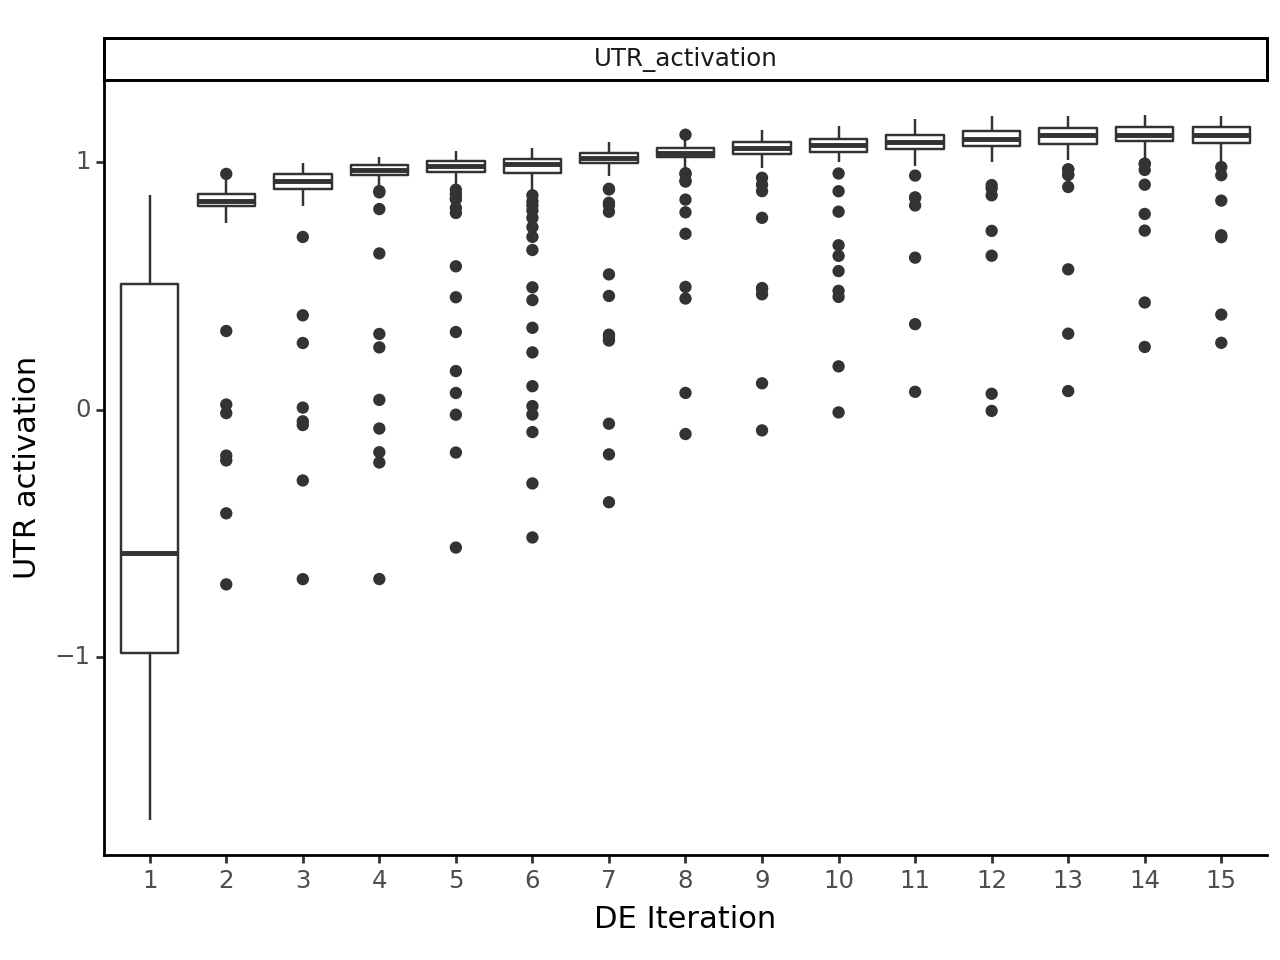

<Figure Size: (640 x 480)>

In [61]:
from grelu.visualize import plot_evolution
import plotnine as p9

plot_evolution(designed_elements) + p9.labs(x='DE Iteration', y='UTR activation')

## Hummingbird designs

In [40]:
from grelu.design.evolve import hummingbird

In [41]:
model = model.to('cuda:1')

In [ ]:
hbseq = hummingbird(model, 50, 100, verbose=True)

basinhopping step 167: f -0.96348 trial_f -0.96348 accepted 1  lowest_f -0.967251
basinhopping step 168: f -0.966584 trial_f -0.966584 accepted 1  lowest_f -0.967251
basinhopping step 169: f -0.969205 trial_f -0.969205 accepted 1  lowest_f -0.969205
found new global minimum on step 169 with function value -0.969205
basinhopping step 170: f -0.966858 trial_f -0.966858 accepted 1  lowest_f -0.969205
basinhopping step 171: f -0.971132 trial_f -0.971132 accepted 1  lowest_f -0.971132
found new global minimum on step 171 with function value -0.971132
basinhopping step 172: f -0.973858 trial_f -0.973858 accepted 1  lowest_f -0.973858
found new global minimum on step 172 with function value -0.973858
basinhopping step 173: f -0.970968 trial_f -0.970968 accepted 1  lowest_f -0.973858
basinhopping step 174: f -0.971663 trial_f -0.971663 accepted 1  lowest_f -0.973858
basinhopping step 175: f -0.971829 trial_f -0.971829 accepted 1  lowest_f -0.973858
basinhopping step 176: f -0.970901 trial_f -0

In [65]:
from grelu.data.dataset import UnlabeledSeqDataset

ds = UnlabeledSeqDataset(hbseq)
hb_preds = model.predict_on_dataset(ds)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

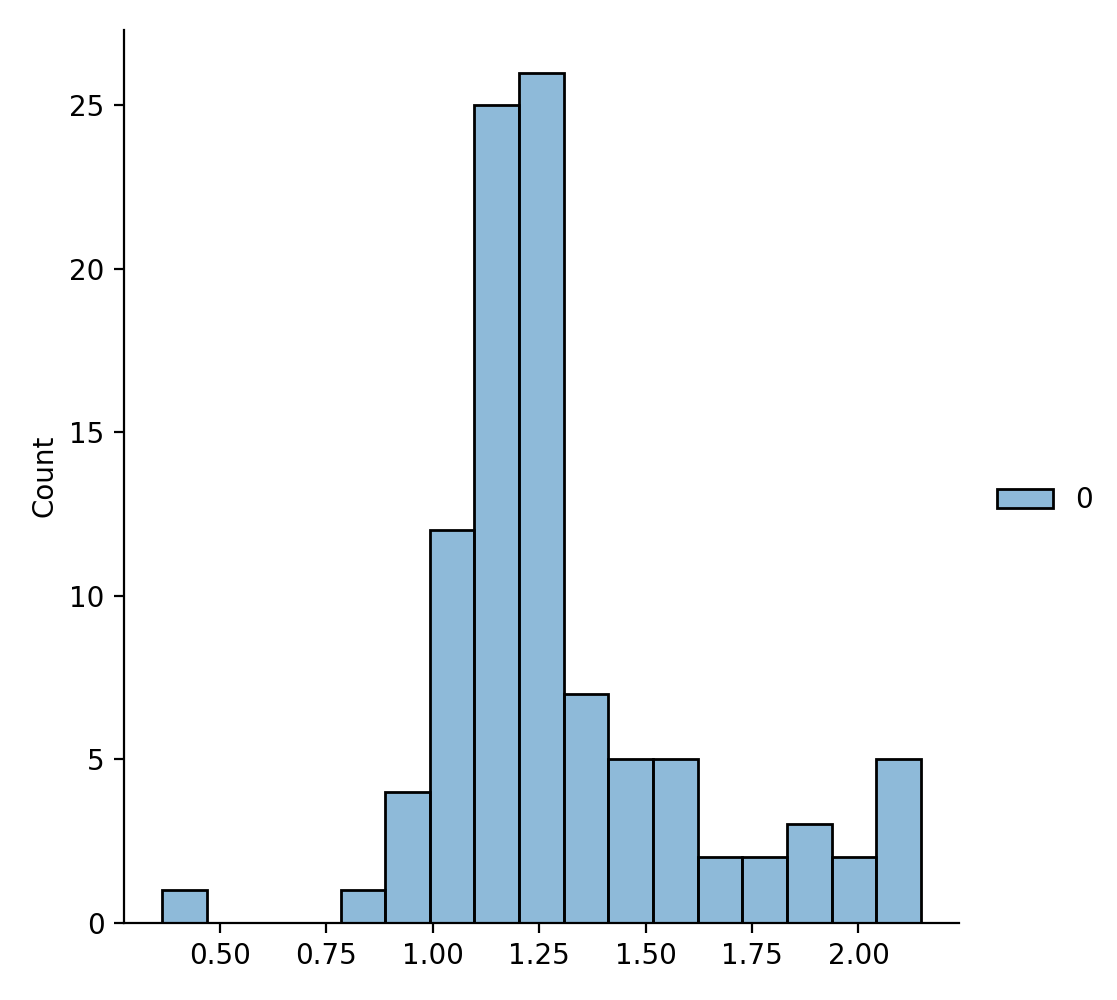

In [66]:
sns.displot(hb_preds)

Add HB sequences next to the evolved ones and visualize

In [81]:
design_df = pd.concat([designed_elements, pd.DataFrame(dict(preds=hb_preds.squeeze(), UTR_activation=hb_preds.squeeze(), seq=hbseq, iter=100))])

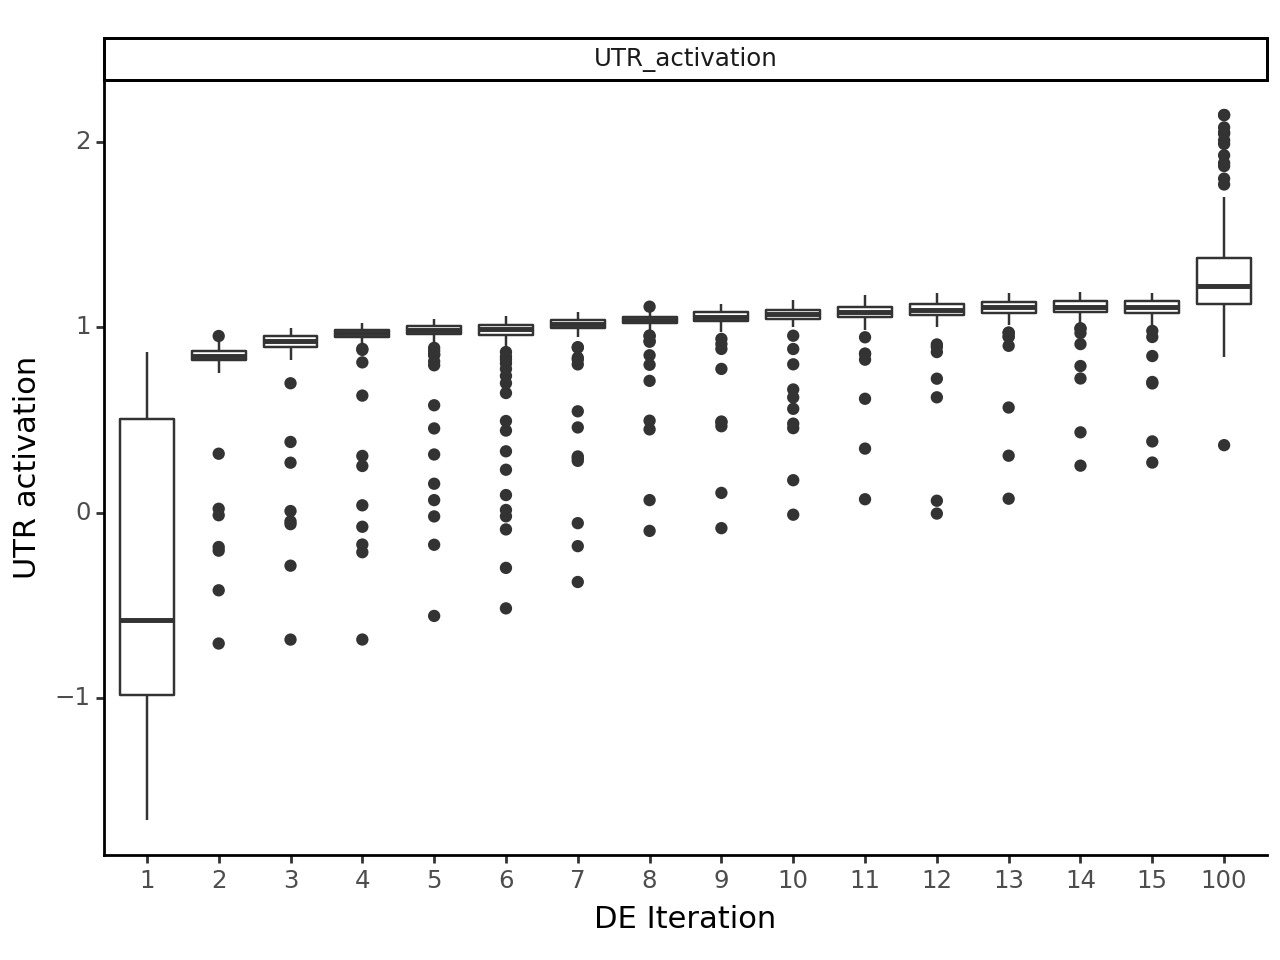

<Figure Size: (640 x 480)>

In [82]:
from grelu.visualize import plot_evolution
import plotnine as p9

plot_evolution(design_df) + p9.labs(x='DE Iteration', y='UTR activation')

In [84]:
pd.options.display.max_colwidth = None

In [85]:
design_df[design_df.iter==100].sort_values('preds', ascending=False).head(20)

,iter,seq,preds,UTR_activation
88,100,AAACCTGCAATCTTTTCTAGCTAGAGCTAGCACTAACAGCCCGGAAATCC,2.14676,2.146760
79,100,CTCGATTTTATAGCTAGCGCTAGCTACTCTTGACACCGGAAGACTGGGAA,2.14598,2.145980
16,100,TTCAGTCTTCCCTGCCAGGGCTAGTAGCTAGCGCTAGGAAAACAAAGAAG,2.079331,2.079331
51,100,CCCGATCGGCACTTTTCACTCTAGCTAGCAGTAGCGCTAGAGGCGGAAAC,2.053329,2.053329
77,100,GCTCAAAACTAGTAGCTAGCTAGCGTGACAGGAAAGGCTGTTTATCACGG,2.045094,2.045094
61,100,GGTTTTAGCATCCGGCAGCGCTAGCTAGCATAGCTATCGCGCGTGTGGAG,2.009933,2.009933
3,100,CCGACTCAAAAGATCGCTAGCAGCTAGCTAGTTCACGTCGAAAGAAACTC,1.990219,1.990219
48,100,GATTTTTACCCTACGAGCTAGCTACAGCATAGCTCTCGCAGAAATCGAAG,1.928719,1.928719
87,100,ATCATTTCACGTAGACGCTAGCAGAGCTAGCTAGGAACAAAGGGTACTGA,1.887481,1.887481
64,100,TCAATCAGGGCTGACTATTCTACTAGCTAGCTGCAGCGGCACAAAGGATC,1.870794,1.870794
